<a href="https://colab.research.google.com/github/marinathomas/SentimentAnalysisHN/blob/master/HN_SentimentAnalysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load credentials to access BigQuery
2. Read the story ids for 2017 from the 'full' table.
3. For each story, get the associated 'main' comments. We are not considering response to the comments for now.
4. Analyze the comments and give the story a score based off the sentiment of the comments.

Step 1 - Load credentials

In [2]:
from google.cloud import bigquery
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = "/content/gdrive/Shared drives/HackerNews:SentimentAnalysis/"
credential_path = root_path+"hackernews-v2-14382f16e9b5.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

Step 2 - Install the sentiment analysis library
https://github.com/cjhutto/vaderSentiment

In [4]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 30.1MB/s 


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

Step 3 - Load BigQuery client and HackerNews dataset
1. Load the BigQuery client
2. Get a reference to HackerNews dataset
3. Load the data set

In [0]:
client = bigquery.Client()
hn_dataset_ref = client.dataset('hacker_news', project='bigquery-public-data')
hn_dset = client.get_dataset(hn_dataset_ref)

Step 4 - Look for stories of 2017

In [0]:
def get_stories():
    query = """
    SELECT *
    FROM `bigquery-public-data.hacker_news.full` as table_full
    WHERE  table_full.type = 'story' and REGEXP_CONTAINS(title, r"(S|s)how HN") 
    and (deleted IS NULL or deleted IS FALSE) and  EXTRACT(YEAR FROM timestamp)=2017
    ORDER BY id asc
    """

    query_job = client.query(query)
    iterator = query_job.result(timeout=30)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    stories = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    #stories.head(10)

    return stories

Lets check the data

In [0]:
import csv

stories = get_stories()
csv_file = root_path + "sentiment_analysis_results/stories_with_more_than_5_comments_2017.csv"
with open(csv_file, mode='w') as stories_file:
  stories_writer = csv.writer(stories_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for index,row in stories.iterrows():
      title, parent_id, score, noOf_comments, url = row['title'], row['id'], row['score'],row['descendants'], row['url']
      stories_writer.writerow([index, title, parent_id, url, noOf_comments])
      #print("----------------------------------------")
      #print('{} Title: {} \t  ID: {} \t url: {} \t descendants:{}'.format(index, title, parent_id, url, noOf_comments))



In [9]:
stories_2017 = get_stories()
stories_2017.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,None,None,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,None,22.0,None,None
1,Show HN: Free Android app that helps to avoid ...,http://sentinews.ml,None,None,hacakton,3,1483230295,2017-01-01 00:24:55+00:00,story,13294002,None,0.0,None,None
2,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,None,None,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,None,6.0,None,None
3,Show HN: Our New Year's Eve Live Stream with J...,None,"Hi Hacker News friends,<p>Last year, the open ...",None,quincyla,4,1483238751,2017-01-01 02:45:51+00:00,story,13294456,None,0.0,None,None
4,Show HN: Codegen – An open source one-time pas...,https://github.com/chrisamanse/Codegen,None,None,chrisamanse,3,1483241586,2017-01-01 03:33:06+00:00,story,13294596,None,0.0,None,None


Let's bring up the comments for the above stories

Step 5 - For each story, bring up the associated comment

In [0]:
def get_comments(parent_id):
    query = """
    select  *
    from `bigquery-public-data.hacker_news.full`  
    where type = 'comment'  and (deleted IS NULL or deleted IS FALSE) and parent = @parent
    order by parent ;
    """

    query_params = [
        bigquery.ScalarQueryParameter("parent", "INT64", parent_id)
    ] 

    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query,location="US",job_config=job_config,)  

    iterator = query_job.result(timeout=300)
    rows = list(iterator)

    #comments = pd.DataFrame()
    # Transform the rows into a nice pandas dataframe
    #if rows:
    comments = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
      #comments.append(comments_temp)
      #comments.head(20)

    return comments

In [0]:
query = """
    select  *
    from `bigquery-public-data.hacker_news.full`  
    where type = 'comment'  and (deleted IS NULL or deleted IS FALSE) and (EXTRACT(YEAR FROM timestamp)=2017 or EXTRACT(YEAR FROM timestamp)=2018)
    order by parent ;
    """

query_job = client.query(query)
iterator = query_job.result(timeout=300)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
comments_all = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))


In [0]:
  csv_file = root_path +  "results/2017/comments/comments_all.csv"
  comments_all.to_csv(csv_file)

In [0]:
stories_2017 = stories_2017.loc[stories_2017['descendants']>0]

In [29]:
stories_2017.shape

(4932, 14)

In [0]:
csv_file = root_path +  "results/2017/story_scores.csv"
stories_with_scores = pd.read_csv(csv_file, index_col=0) 

In [31]:
stories_with_scores.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,active,vader_max_neg_top,vader_avg_neg_top,vader_max_pos_top,vader_avg_pos_top,vader_max_compound_top,vader_min_compound_top,vader_avg_compound_top,vader_max_neg,vader_avg_neg,vader_max_pos,vader_avg_pos,vader_max_compound,vader_min_compound,vader_avg_compound,textblob_max_polarity_top,textblob_min_polarity_top,textblob_avg_polarity_top,textblob_max_polarity,textblob_min_polarity,textblob_avg_polarity,textblob_avg_subjective,textblob_avg_objective,vader_avg_compound_subjective,vader_avg_compound_objective
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,NaN,NaN,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,NaN,22.0,NaN,NaN,False,0.061,0.0075,0.301,0.153417,0.9622,0.0000,0.551942,0.061,0.0075,0.301,0.153417,0.9622,0.0000,0.551942,0.550000,-0.100000,0.271114,0.550000,-0.100000,0.271114,0.310035,0.216625,0.4863,0.64384
1,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,NaN,NaN,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,NaN,6.0,NaN,NaN,False,0.000,0.0000,0.247,0.155400,0.8423,0.0000,0.486340,0.000,0.0000,0.247,0.155400,0.8423,0.0000,0.486340,0.600000,-0.156250,0.184553,0.600000,-0.156250,0.184553,0.359672,-0.078125,0.5298,0.42115
2,Show HN: Math Worksheets for Kids,http://worksheets.guru/,NaN,NaN,javierluraschi,18,1483257608,2017-01-01 08:00:08+00:00,story,13295049,NaN,8.0,NaN,NaN,False,0.000,0.0000,0.341,0.240000,0.6908,0.4404,0.565600,0.000,0.0000,0.341,0.240000,0.6908,0.4404,0.565600,0.333333,-0.500000,-0.083333,0.333333,-0.500000,-0.083333,-0.083333,0.000000,0.5656,0.00000
3,"Show HN: Soda Player, a “modern” player app",https://www.sodaplayer.com/,NaN,NaN,sodaplayer_team,5,1483257848,2017-01-01 08:04:08+00:00,story,13295057,NaN,2.0,NaN,NaN,True,0.057,0.0570,0.060,0.060000,0.3356,0.3356,0.335600,0.057,0.0570,0.060,0.060000,0.3356,0.3356,0.335600,0.025397,0.025397,0.025397,0.025397,0.025397,0.025397,0.000000,0.025397,0.0000,0.33560
4,Show HN: TopShots – Your top nine Dribbble sho...,https://topshots.co/,NaN,NaN,iisbum,7,1483284127,2017-01-01 15:22:07+00:00,story,13295998,NaN,1.0,NaN,NaN,True,0.000,0.0000,0.264,0.264000,0.9186,0.9186,0.918600,0.000,0.0000,0.264,0.264000,0.9186,0.9186,0.918600,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.000000,0.9186,0.00000


In [32]:
stories_with_scores.shape

(4933, 39)

In [33]:
import numpy as np

comments_2017 = pd.DataFrame()
for index, story in stories_with_scores.iterrows():
  parent_id = story['id'] #13292636 #13425089 #
  #fileName = "comments_"+str(id)+".csv"
  #if fileName in comment_files:
  #  continue
  #print(id)
  #bad_ids = [13425089, 15916350, 13658716, 13677748, 13975932]
  #if id in bad_ids:
  #  continue
  story_comments=pd.DataFrame()
  comment_ids = []
  count = 0;

  story_comments = comments_all.loc[comments_all['parent']== parent_id]
  story_comments['level'] = 1
  comment_ids = story_comments['id'].to_numpy()
  #if id == 13425089:
  #  print(comment_ids)
  #print(len(story_comments))
  #print(story['descendants'])
  found_all = True
  while len(story_comments) < story['descendants']:
    if count == len(comment_ids):
      print(parent_id)
      found_all = False
      break
    id = comment_ids[count]
    #print(id)
    temp = comments_all.loc[comments_all['parent']== id]
    temp['level'] = 2
    story_comments = pd.concat([story_comments, temp])
    comment_ids = np.concatenate((comment_ids, temp['id'].to_numpy()))
    count += 1
    #print(len(temp))
    #print(len(comment_ids))
  #break;
  #print(comment_ids)

  #print(len(story_comments))
  #story_comments.head() 
  print('total  {} found  {}'.format(story['descendants'], comment_ids))
  #csv_file = root_path +  "results/2017/comments/"+fileName
  #story_comments.to_csv(csv_file)
  #break
  if found_all:
    comments_2017 = pd.concat([comments_2017,story_comments])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total  22.0 found  [13301045 13294587 13294578 13295525 13294932 13295662 13295947 13295898
 13294475 13294860 13295776 13294889 13294654 13300974 13296439 13294937
 13295470 13295413 13303446 13296518 13300813 13295812]
total  6.0 found  [13294686 13294857 13295655 13294862 13294875 13294958]
total  8.0 found  [13296902 13347169 13297733 13347177 13301338 13300192 13301077 13301965]
total  2.0 found  [13295734 13295787]
total  1.0 found  [13296017]
total  5.0 found  [13299190 13299350 13302309 13302328 13303870]
total  1.0 found  [13296923]
total  30.0 found  [13298799 13298141 13298766 13297386 13297247 13300186 13301853 13297243
 13297662 13297986 13298842 13298281 13297621 13298107 13297526 13297610
 13297335 13297685 13298967 13299852 13298975 13298097 13298679 13298925
 13298850 13317144 13298259 13300374 13319727 13317133]
total  1.0 found  [13298844]
total  2.0 found  [13301487 13301642]
total  1.0 found  [13302731]
total  61.0 found  [13305360 13304695 13309105 13304112 133034

In [34]:
 comments_2017.shape
 

(59664, 15)

In [37]:
comments_2017['parent'].unique().shape

(32145,)

In [0]:
csv_file = root_path +  "results/2017/comments/comments_2017_all.csv"
comments_2017.to_csv(csv_file)

In [0]:
csv_file = root_path +  "results/2017/story_scores.csv"
stories_with_scores = pd.read_csv(csv_file, index_col=0) 


In [0]:
csv_file = root_path +  "results/2017/comments/comments_2017_all.csv"
comments_2017 = pd.read_csv(csv_file, index_col=0) 

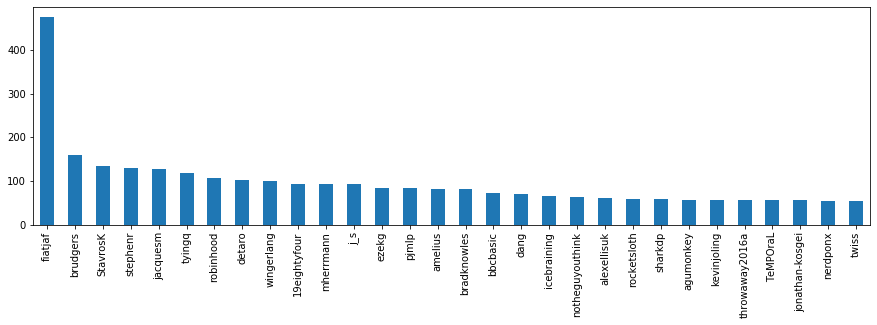

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4))
comments_2017['by'].value_counts()[:30].plot(kind='bar')


Step 6 - Analyse comments

In [29]:
processed = 0
def get_sentiment_score(row):
  global processed
  processed += 1
  if processed % 1000 == 0:
    print("|", end="")
  return analyser.polarity_scores(str(row['text']))

comments_2017['score'] = comments_2017.apply(get_sentiment_score,axis=1)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [0]:
comments_2017_file = root_path +  "results/2017/comments_2017_all.csv"
comments_2017.to_csv(comments_2017_file)

In [0]:
csv_file = root_path +  "results/2017/comments_2017_all.csv"
comments_2017 = pd.read_csv(csv_file, index_col=0) 

In [0]:
comments_2017['neg'] = comments_2017.apply(lambda x: x['score']['neg'],axis=1)
comments_2017['pos'] = comments_2017.apply(lambda x: x['score']['pos'],axis=1)
comments_2017['neu'] = comments_2017.apply(lambda x: x['score']['neu'],axis=1)
comments_2017['compound'] = comments_2017.apply(lambda x: x['score']['compound'],axis=1)

In [32]:
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [0]:
from textblob import TextBlob

processed = 0
def get_textblob_sentiment_score(row):
  global processed
  processed += 1
  if processed % 1000 == 0:
    print("|", end="")
  tb = TextBlob(str(row['text']))
  return (tb.sentiment,len(tb.words))

In [34]:
comments_2017['textblob_data'] = comments_2017.apply(get_textblob_sentiment_score,axis=1)
comments_2017['textblob_score'] = comments_2017.apply(lambda x: x['textblob_data'][0],axis=1)
comments_2017['wordcount'] = comments_2017.apply(lambda x: x['textblob_data'][1],axis=1)
comments_2017.head()

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,level,neg,pos,neu,compound,textblob_data,textblob_score,wordcount
1214,NaN,NaN,Some time ago I worked on a tool for powering ...,NaN,codazoda,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",1483363979,2017-01-02 13:32:59+00:00,comment,13301045,13293894,NaN,NaN,NaN,1,0.000,0.139,0.861,0.7876,"((0.55, 0.75), 70)","(0.55, 0.75)",70
1215,NaN,NaN,"Cool, so does it blink for all http requests i...",NaN,grimmdude,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",1483241437,2017-01-01 03:30:37+00:00,comment,13294587,13293894,NaN,NaN,NaN,1,0.000,0.187,0.813,0.3182,"((0.35, 0.65), 13)","(0.35, 0.65)",13
1216,NaN,NaN,"Random Linux trivia&#x2F;story: Back in 2002,...",NaN,elihu,"{'neg': 0.029, 'neu': 0.935, 'pos': 0.036, 'co...",1483241357,2017-01-01 03:29:17+00:00,comment,13294578,13293894,NaN,NaN,NaN,1,0.029,0.036,0.935,0.2023,"((-0.002777777777777768, 0.5194444444444444), ...","(-0.002777777777777768, 0.5194444444444444)",156
1217,NaN,NaN,Maybe a use for my otherwise waste-of-space ma...,NaN,StringyBob,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1483272902,2017-01-01 12:15:02+00:00,comment,13295525,13293894,NaN,NaN,NaN,1,0.000,0.000,1.000,0.0000,"((0.4, 0.75), 18)","(0.4, 0.75)",18
1218,NaN,NaN,This is awesome! I believe it was Bob Metcalf ...,NaN,ChuckMcM,"{'neg': 0.061, 'neu': 0.775, 'pos': 0.164, 'co...",1483253100,2017-01-01 06:45:00+00:00,comment,13294932,13293894,NaN,NaN,NaN,1,0.061,0.164,0.775,0.9239,"((0.3889285714285714, 0.6171428571428571), 128)","(0.3889285714285714, 0.6171428571428571)",128


In [0]:
comments_2017['polarity'] = comments_2017.apply(lambda x: x['textblob_score'].polarity,axis=1)
comments_2017['subjectivity'] = comments_2017.apply(lambda x: x['textblob_score'].subjectivity,axis=1)

In [51]:
import numpy as np

comments_2017['parent_story'] = 0
for index, story in stories_with_scores.iterrows():
  parent_id = story['id'] #13292636 #13425089 #
  comment_ids = []
  count = 0;
  
  comments_2017['parent_story'] = np.where(comments_2017['parent']== parent_id, parent_id,comments_2017['parent_story'])
  comment_ids = comments_2017.loc[comments_2017['parent']== parent_id]['id'].to_numpy()
  while len(comment_ids) < story['descendants']:
    if count == len(comment_ids):
      print(parent_id)
      found_all = False
      break
    id = comment_ids[count]
    #print(id)
    comments_2017['parent_story'] = np.where(comments_2017['parent']== id, parent_id,comments_2017['parent_story'])
    temp = comments_2017.loc[comments_2017['parent']== id]['id'].to_numpy()
    #comment_ids
    #print(temp)
    #if temp:
    comment_ids = np.concatenate((comment_ids, temp))
    count += 1
  print('total  {} found  {}'.format(story['descendants'], comment_ids))
  #break;


total  22.0 found  [13301045 13294587 13294578 13295525 13294932 13295662 13295947 13295898
 13294475 13294860 13295776 13294889 13294654 13300974 13296439 13294937
 13295470 13295413 13303446 13296518 13300813 13295812]
total  6.0 found  [13294686 13294857 13295655 13294862 13294875 13294958]
total  8.0 found  [13296902 13347169 13297733 13347177 13301338 13300192 13301077 13301965]
total  2.0 found  [13295734 13295787]
total  1.0 found  [13296017]
total  5.0 found  [13299190 13299350 13302309 13302328 13303870]
total  1.0 found  [13296923]
total  30.0 found  [13298799 13298141 13298766 13297386 13297247 13300186 13301853 13297243
 13297662 13297986 13298842 13298281 13297621 13298107 13297526 13297610
 13297335 13297685 13298967 13299852 13298975 13298097 13298679 13298925
 13298850 13317144 13298259 13300374 13319727 13317133]
total  1.0 found  [13298844]
total  2.0 found  [13301487 13301642]
total  1.0 found  [13302731]
total  61.0 found  [13305360 13304695 13309105 13304112 133034

In [56]:
comments_2017.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,level,neg,pos,neu,compound,textblob_data,textblob_score,wordcount,parent_story,vader_sentiment_label
1214,NaN,NaN,Some time ago I worked on a tool for powering ...,NaN,codazoda,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",1483363979,2017-01-02 13:32:59+00:00,comment,13301045,13293894,NaN,NaN,NaN,1,0.000,0.139,0.861,0.7876,"((0.55, 0.75), 70)","(0.55, 0.75)",70,13293894,Positive
1215,NaN,NaN,"Cool, so does it blink for all http requests i...",NaN,grimmdude,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",1483241437,2017-01-01 03:30:37+00:00,comment,13294587,13293894,NaN,NaN,NaN,1,0.000,0.187,0.813,0.3182,"((0.35, 0.65), 13)","(0.35, 0.65)",13,13293894,Positive
1216,NaN,NaN,"Random Linux trivia&#x2F;story: Back in 2002,...",NaN,elihu,"{'neg': 0.029, 'neu': 0.935, 'pos': 0.036, 'co...",1483241357,2017-01-01 03:29:17+00:00,comment,13294578,13293894,NaN,NaN,NaN,1,0.029,0.036,0.935,0.2023,"((-0.002777777777777768, 0.5194444444444444), ...","(-0.002777777777777768, 0.5194444444444444)",156,13293894,Positive
1217,NaN,NaN,Maybe a use for my otherwise waste-of-space ma...,NaN,StringyBob,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1483272902,2017-01-01 12:15:02+00:00,comment,13295525,13293894,NaN,NaN,NaN,1,0.000,0.000,1.000,0.0000,"((0.4, 0.75), 18)","(0.4, 0.75)",18,13293894,Neutral
1218,NaN,NaN,This is awesome! I believe it was Bob Metcalf ...,NaN,ChuckMcM,"{'neg': 0.061, 'neu': 0.775, 'pos': 0.164, 'co...",1483253100,2017-01-01 06:45:00+00:00,comment,13294932,13293894,NaN,NaN,NaN,1,0.061,0.164,0.775,0.9239,"((0.3889285714285714, 0.6171428571428571), 128)","(0.3889285714285714, 0.6171428571428571)",128,13293894,Positive


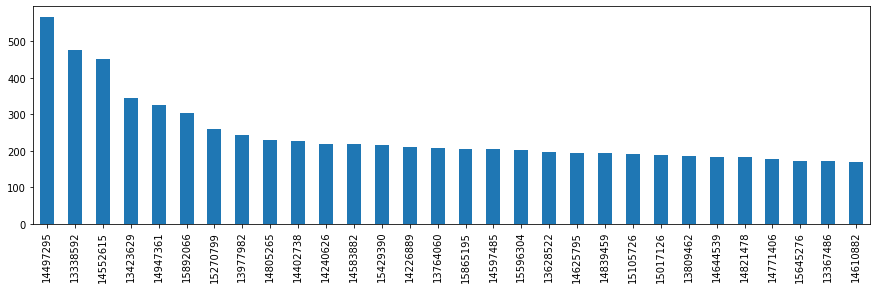

In [60]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4))
comments_2017['parent_story'].value_counts()[:30].plot(kind='bar')


In [0]:
comments_2017['vader_sentiment_label'] = comments_2017.apply(lambda x:  'Positive' if x['compound'] > .05  else 'Negative' if x['compound'] < -.05 else 'Neutral' ,axis=1)
comments_2017['textblob_sentiment_label'] = comments_2017.apply(lambda x:  'Positive' if x['polarity'] > .05  else 'Negative' if x['polarity'] < -.05 else 'Neutral' ,axis=1)
comments_2017['textblob_subjectivity_label'] = comments_2017.apply(lambda x:  'Subjective' if x['subjectivity'] >= .5  else 'Objective' ,axis=1)

In [38]:
print(comments_2017['parent_story'].unique())

[13293894        0]


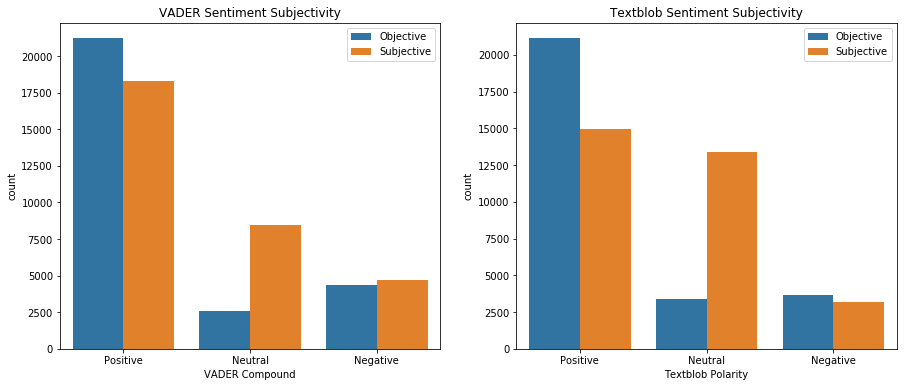

In [65]:
import seaborn as sns

#sns.set(style="darkgrid")
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,6)

vax = sns.countplot(x="vader_sentiment_label",hue="textblob_subjectivity_label", data=comments_2017, ax=ax[0])
vax.set_title('VADER Sentiment Subjectivity')
vax.set_xlabel('VADER Compound')
vax.legend(['Objective','Subjective'])

tax = sns.countplot(x="textblob_sentiment_label",hue="textblob_subjectivity_label", data=comments_2017, ax=ax[1])
tax.set_title('Textblob Sentiment Subjectivity')
tax.set_xlabel('Textblob Polarity')
tax.legend(['Objective','Subjective'])

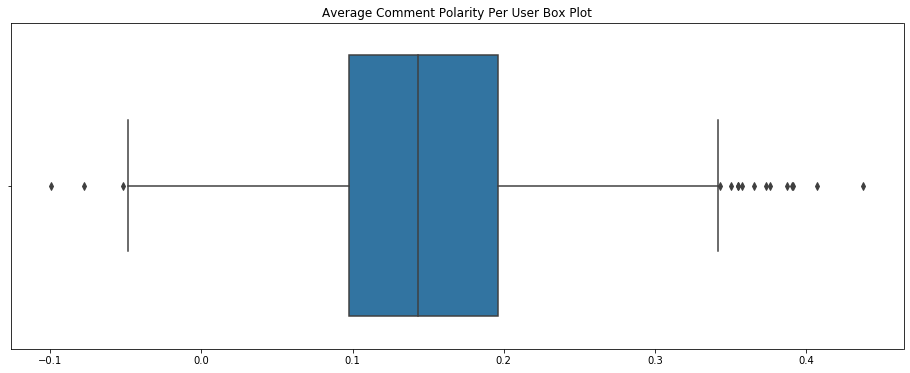

In [66]:
# this shows users are relatively neutral and dont' always give negative or positive feedback, this shows fairness in there comments
gr = comments_2017[['by','polarity']].groupby('by').agg(['mean','count'])
gr.columns=['mean','count']
#gr = gr[gr['count']>10]

plt.figure(figsize=(16, 6))
plt.title('Average Comment Polarity Per User Box Plot')
sns.boxplot(x=gr[gr['count']>10][['mean']])

In [68]:
comments_2017['wordcount'].describe()

count    59664.000000
mean        54.352725
std         65.102850
min          0.000000
25%         18.000000
50%         36.000000
75%         67.000000
max       1705.000000
Name: wordcount, dtype: float64

Text(0, 0.5, 'TextBlob comment sentiment scores')

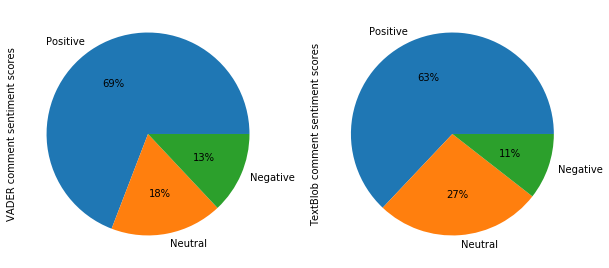

In [69]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(10,5)

vax = comments_2017[comments_2017['level']==1]['vader_sentiment_label'].value_counts().plot(kind='pie',ax=ax[0],autopct='%1.0f%%')
vax.set_ylabel('VADER comment sentiment scores')

tax = comments_2017[comments_2017['level']==1]['textblob_sentiment_label'].value_counts().plot(kind='pie',ax=ax[1],autopct='%1.0f%%')
tax.set_ylabel('TextBlob comment sentiment scores')

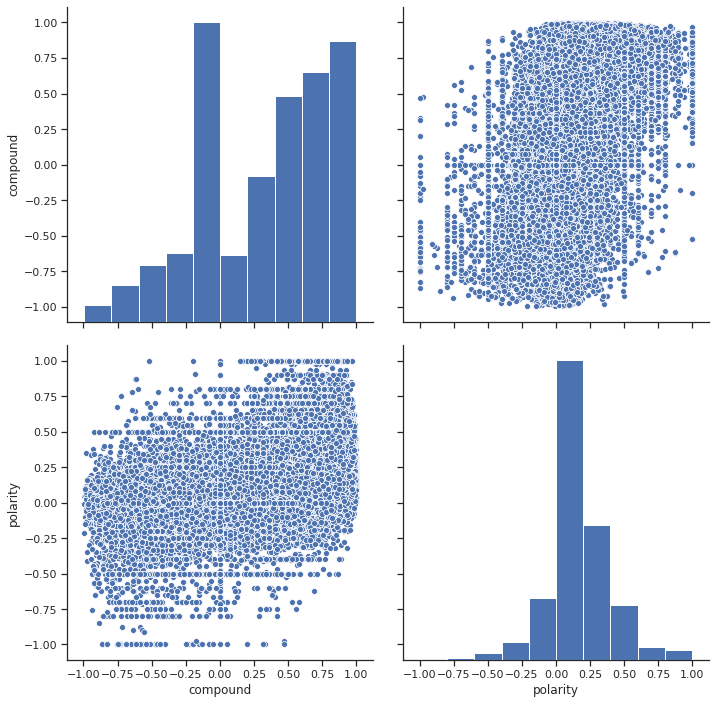

In [70]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(comments_2017, vars=["compound", "polarity"], height=5)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
stories_with_scores['vader_max_neg_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['neg'].max(),axis=1)
stories_with_scores['vader_avg_neg_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['neg'].mean(),axis=1)

stories_with_scores['vader_max_pos_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['pos'].max(),axis=1)
stories_with_scores['vader_avg_pos_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['pos'].mean(),axis=1)

stories_with_scores['vader_max_compound_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].max(),axis=1)
stories_with_scores['vader_min_compound_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].min(),axis=1)
stories_with_scores['vader_avg_compound_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].mean(),axis=1)

stories_with_scores['vader_max_neg'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['neg'].max(),axis=1)
stories_with_scores['vader_avg_neg'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['neg'].mean(),axis=1)

stories_with_scores['vader_max_pos'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['pos'].max(),axis=1)
stories_with_scores['vader_avg_pos'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['pos'].mean(),axis=1)

stories_with_scores['vader_max_compound'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].max(),axis=1)
stories_with_scores['vader_min_compound'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].min(),axis=1)
stories_with_scores['vader_avg_compound'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['compound'].mean(),axis=1)



,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,active,vader_max_neg_top,vader_avg_neg_top,vader_max_pos_top,vader_avg_pos_top,vader_max_compound_top,vader_min_compound_top,vader_avg_compound_top,vader_max_neg,vader_avg_neg,vader_max_pos,vader_avg_pos,vader_max_compound,vader_min_compound,vader_avg_compound,textblob_max_polarity_top,textblob_min_polarity_top,textblob_avg_polarity_top,textblob_max_polarity,textblob_min_polarity,textblob_avg_polarity,textblob_avg_subjective,textblob_avg_objective,vader_avg_compound_subjective,vader_avg_compound_objective,wordcount_avg,is_github
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,NaN,NaN,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,NaN,22.0,NaN,NaN,False,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.550000,-0.100000,0.271114,0.550000,-0.150000,0.166898,0.310035,0.216625,0.4863,0.64384,63.25,False
1,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,NaN,NaN,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,NaN,6.0,NaN,NaN,False,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.600000,-0.156250,0.184553,0.600000,-0.156250,0.216294,0.359672,-0.078125,0.5298,0.42115,37.00,True
2,Show HN: Math Worksheets for Kids,http://worksheets.guru/,NaN,NaN,javierluraschi,18,1483257608,2017-01-01 08:00:08+00:00,story,13295049,NaN,8.0,NaN,NaN,False,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.333333,-0.500000,-0.083333,0.333333,-0.500000,0.032807,-0.083333,0.000000,0.5656,0.00000,24.50,False
3,"Show HN: Soda Player, a “modern” player app",https://www.sodaplayer.com/,NaN,NaN,sodaplayer_team,5,1483257848,2017-01-01 08:04:08+00:00,story,13295057,NaN,2.0,NaN,NaN,True,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.025397,0.025397,0.025397,0.330000,0.025397,0.177698,0.000000,0.025397,0.0000,0.33560,119.00,False
4,Show HN: TopShots – Your top nine Dribbble sho...,https://topshots.co/,NaN,NaN,iisbum,7,1483284127,2017-01-01 15:22:07+00:00,story,13295998,NaN,1.0,NaN,NaN,True,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.000000,0.9186,0.00000,51.00,False


In [107]:
stories_with_scores['vader_avg_compound'] = stories_with_scores['vader_avg_compound'].fillna(0)
stories_with_scores['vader_avg_pos'] = stories_with_scores['vader_avg_pos'].fillna(0)
stories_with_scores['vader_avg_neg'] = stories_with_scores['vader_avg_neg'].fillna(0)
stories_with_scores['vader_avg_compound_top'] = stories_with_scores['vader_avg_compound_top'].fillna(0)
stories_with_scores.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,active,vader_max_neg_top,vader_avg_neg_top,vader_max_pos_top,vader_avg_pos_top,vader_max_compound_top,vader_min_compound_top,vader_avg_compound_top,vader_max_neg,vader_avg_neg,vader_max_pos,vader_avg_pos,vader_max_compound,vader_min_compound,vader_avg_compound,textblob_max_polarity_top,textblob_min_polarity_top,textblob_avg_polarity_top,textblob_max_polarity,textblob_min_polarity,textblob_avg_polarity,textblob_avg_subjective,textblob_avg_objective,vader_avg_compound_subjective,vader_avg_compound_objective,wordcount_avg,is_github
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,NaN,NaN,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,NaN,22.0,NaN,NaN,False,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.550000,-0.150000,0.166898,0.550000,-0.150000,0.166898,0.221402,0.112395,0.327027,0.312682,54.090909,False
1,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,NaN,NaN,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,NaN,6.0,NaN,NaN,False,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.600000,-0.156250,0.216294,0.600000,-0.156250,0.216294,0.359672,0.072917,0.529800,0.569367,38.666667,True
2,Show HN: Math Worksheets for Kids,http://worksheets.guru/,NaN,NaN,javierluraschi,18,1483257608,2017-01-01 08:00:08+00:00,story,13295049,NaN,8.0,NaN,NaN,False,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.333333,-0.500000,0.032807,0.333333,-0.500000,0.032807,-0.009028,0.074642,0.600675,0.660650,40.875000,False
3,"Show HN: Soda Player, a “modern” player app",https://www.sodaplayer.com/,NaN,NaN,sodaplayer_team,5,1483257848,2017-01-01 08:04:08+00:00,story,13295057,NaN,2.0,NaN,NaN,True,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.330000,0.025397,0.177698,0.330000,0.025397,0.177698,0.330000,0.025397,0.542300,0.335600,77.500000,False
4,Show HN: TopShots – Your top nine Dribbble sho...,https://topshots.co/,NaN,NaN,iisbum,7,1483284127,2017-01-01 15:22:07+00:00,story,13295998,NaN,1.0,NaN,NaN,True,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.000000,0.918600,0.000000,51.000000,False


In [0]:
stories_with_score_2017_file = root_path +  "results/2017/stories_2017_all.csv"
stories_with_scores.to_csv(stories_with_score_2017_file)

In [91]:
stories_with_scores['textblob_max_polarity_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].max(),axis=1)
stories_with_scores['textblob_min_polarity_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].min(),axis=1)
stories_with_scores['textblob_avg_polarity_top'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].mean(),axis=1)

stories_with_scores['textblob_max_polarity'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].max(),axis=1)
stories_with_scores['textblob_min_polarity'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].min(),axis=1)
stories_with_scores['textblob_avg_polarity'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['polarity'].mean(),axis=1)

stories_with_scores.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,active,vader_max_neg_top,vader_avg_neg_top,vader_max_pos_top,vader_avg_pos_top,vader_max_compound_top,vader_min_compound_top,vader_avg_compound_top,vader_max_neg,vader_avg_neg,vader_max_pos,vader_avg_pos,vader_max_compound,vader_min_compound,vader_avg_compound,textblob_max_polarity_top,textblob_min_polarity_top,textblob_avg_polarity_top,textblob_max_polarity,textblob_min_polarity,textblob_avg_polarity,textblob_avg_subjective,textblob_avg_objective,vader_avg_compound_subjective,vader_avg_compound_objective,wordcount_avg,is_github
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,NaN,NaN,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,NaN,22.0,NaN,NaN,False,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.550000,-0.150000,0.166898,0.550000,-0.150000,0.166898,0.310035,0.216625,0.4863,0.64384,63.25,False
1,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,NaN,NaN,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,NaN,6.0,NaN,NaN,False,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.600000,-0.156250,0.216294,0.600000,-0.156250,0.216294,0.359672,-0.078125,0.5298,0.42115,37.00,True
2,Show HN: Math Worksheets for Kids,http://worksheets.guru/,NaN,NaN,javierluraschi,18,1483257608,2017-01-01 08:00:08+00:00,story,13295049,NaN,8.0,NaN,NaN,False,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.333333,-0.500000,0.032807,0.333333,-0.500000,0.032807,-0.083333,0.000000,0.5656,0.00000,24.50,False
3,"Show HN: Soda Player, a “modern” player app",https://www.sodaplayer.com/,NaN,NaN,sodaplayer_team,5,1483257848,2017-01-01 08:04:08+00:00,story,13295057,NaN,2.0,NaN,NaN,True,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.330000,0.025397,0.177698,0.330000,0.025397,0.177698,0.000000,0.025397,0.0000,0.33560,119.00,False
4,Show HN: TopShots – Your top nine Dribbble sho...,https://topshots.co/,NaN,NaN,iisbum,7,1483284127,2017-01-01 15:22:07+00:00,story,13295998,NaN,1.0,NaN,NaN,True,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.000000,0.9186,0.00000,51.00,False


In [0]:
stories_with_scores['textblob_avg_polarity'] = stories_with_scores['textblob_avg_polarity'].fillna(0)
stories_with_scores['textblob_avg_polarity_top'] = stories_with_scores['textblob_avg_polarity'].fillna(0)

In [0]:
stories_with_scores['textblob_avg_subjective'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id][comments_2017['subjectivity'] > 0.5]['polarity'].mean(),axis=1)
stories_with_scores['textblob_avg_subjective'] = stories_with_scores['textblob_avg_subjective'].fillna(0);

stories_with_scores['textblob_avg_objective'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id][comments_2017['subjectivity'] <= 0.5]['polarity'].mean(),axis=1)
stories_with_scores['textblob_avg_objective'] = stories_with_scores['textblob_avg_objective'].fillna(0);

stories_with_scores['vader_avg_compound_subjective'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id][comments_2017['subjectivity'] > 0.5]['compound'].mean(),axis=1)
stories_with_scores['vader_avg_compound_subjective'] = stories_with_scores['vader_avg_compound_subjective'].fillna(0);

stories_with_scores['vader_avg_compound_objective'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id][comments_2017['subjectivity'] <= 0.5]['compound'].mean(),axis=1)
stories_with_scores['vader_avg_compound_objective'] = stories_with_scores['vader_avg_compound_objective'].fillna(0);

In [0]:
stories_with_scores['wordcount_avg'] = stories_with_scores.apply(lambda x: comments_2017[comments_2017['parent_story'] == x.id]['wordcount'].mean(),axis=1)

In [0]:
stories_with_scores['wordcount_avg'] = stories_with_scores['wordcount_avg'].fillna(0);

In [0]:
for index, story in stories_with_scores.iterrows():
  if story['wordcount_avg']==None:
    print(story)

In [0]:
stories_with_scores['is_github'] = stories_with_scores.apply(lambda x: str(x['url']).find('github.') != -1,axis=1)

In [95]:
stories_with_scores.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted,active,vader_max_neg_top,vader_avg_neg_top,vader_max_pos_top,vader_avg_pos_top,vader_max_compound_top,vader_min_compound_top,vader_avg_compound_top,vader_max_neg,vader_avg_neg,vader_max_pos,vader_avg_pos,vader_max_compound,vader_min_compound,vader_avg_compound,textblob_max_polarity_top,textblob_min_polarity_top,textblob_avg_polarity_top,textblob_max_polarity,textblob_min_polarity,textblob_avg_polarity,textblob_avg_subjective,textblob_avg_objective,vader_avg_compound_subjective,vader_avg_compound_objective,wordcount_avg,is_github
0,Show HN: Blink my keyboard lights when you vis...,http://lelandbatey.com/posts/2016/12/Making-li...,NaN,NaN,lelandbatey,87,1483228883,2017-01-01 00:01:23+00:00,story,13293894,NaN,22.0,NaN,NaN,False,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.122,0.024318,0.420,0.140364,0.9622,-0.7968,0.319855,0.550000,-0.150000,0.166898,0.550000,-0.150000,0.166898,0.221402,0.112395,0.327027,0.312682,54.090909,False
1,Show HN: Shadowsocks-rust – A fast SOCKSv5 pro...,https://github.com/loggerhead/shadowsocks-rust,NaN,NaN,loggerhead,68,1483237276,2017-01-01 02:21:16+00:00,story,13294375,NaN,6.0,NaN,NaN,False,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.031,0.005167,0.247,0.165833,0.8658,0.0000,0.549583,0.600000,-0.156250,0.216294,0.600000,-0.156250,0.216294,0.359672,0.072917,0.529800,0.569367,38.666667,True
2,Show HN: Math Worksheets for Kids,http://worksheets.guru/,NaN,NaN,javierluraschi,18,1483257608,2017-01-01 08:00:08+00:00,story,13295049,NaN,8.0,NaN,NaN,False,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.096,0.028500,0.341,0.182750,0.9169,0.2942,0.630663,0.333333,-0.500000,0.032807,0.333333,-0.500000,0.032807,-0.009028,0.074642,0.600675,0.660650,40.875000,False
3,"Show HN: Soda Player, a “modern” player app",https://www.sodaplayer.com/,NaN,NaN,sodaplayer_team,5,1483257848,2017-01-01 08:04:08+00:00,story,13295057,NaN,2.0,NaN,NaN,True,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.063,0.060000,0.154,0.107000,0.5423,0.3356,0.438950,0.330000,0.025397,0.177698,0.330000,0.025397,0.177698,0.330000,0.025397,0.542300,0.335600,77.500000,False
4,Show HN: TopShots – Your top nine Dribbble sho...,https://topshots.co/,NaN,NaN,iisbum,7,1483284127,2017-01-01 15:22:07+00:00,story,13295998,NaN,1.0,NaN,NaN,True,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.000,0.000000,0.264,0.264000,0.9186,0.9186,0.918600,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.650000,0.000000,0.918600,0.000000,51.000000,False


In [0]:
columns = ['score'
  ,'descendants'
  #,'score'
  #,'ratio'
  ,'wordcount_avg'
  ,'is_github'
  #,'vader_max_neg'
  #,'vader_avg_neg'
  #,'vader_max_pos'
  #,'vader_avg_pos'
  #,'vader_max_compound'
  #,'vader_min_compound'
  ,'vader_avg_compound'
  #,'vader_max_neg_top'
  #,'vader_avg_neg_top'
  #,'vader_max_pos_top'
  #,'vader_avg_pos_top'
  #,'vader_max_compound_top'
  #,'vader_min_compound_top'
  ,'vader_avg_compound_top'
  #,'textblob_max_polarity'
  #,'textblob_min_polarity'
  ,'textblob_avg_polarity'
  #,'textblob_max_polarity_top'
  #,'textblob_min_polarity_top'
  ,'textblob_avg_polarity_top'
  ,'textblob_avg_subjective'
  ,'textblob_avg_objective'
  ,'vader_avg_compound_subjective'
  ,'vader_avg_compound_objective'
  ]
  
X = stories_with_scores[columns]
y = stories_with_scores[['active']]



In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [130]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=0,n_jobs=-1)
m = clf.fit(X_train,y_train)

predictions = m.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

       False       0.63      0.77      0.69       903
        True       0.45      0.30      0.36       577

    accuracy                           0.59      1480
   macro avg       0.54      0.53      0.53      1480
weighted avg       0.56      0.59      0.56      1480

[[693 210]
 [404 173]]


In [124]:
y.isnull().values.sum()

0

In [0]:
y=y.fillna(value=False)

In [116]:
X.isna().any()

score                            False
descendants                      False
wordcount_avg                    False
is_github                        False
vader_avg_compound               False
vader_avg_compound_top           False
textblob_avg_polarity            False
textblob_avg_polarity_top        False
textblob_avg_subjective          False
textblob_avg_objective           False
vader_avg_compound_subjective    False
vader_avg_compound_objective     False
dtype: bool

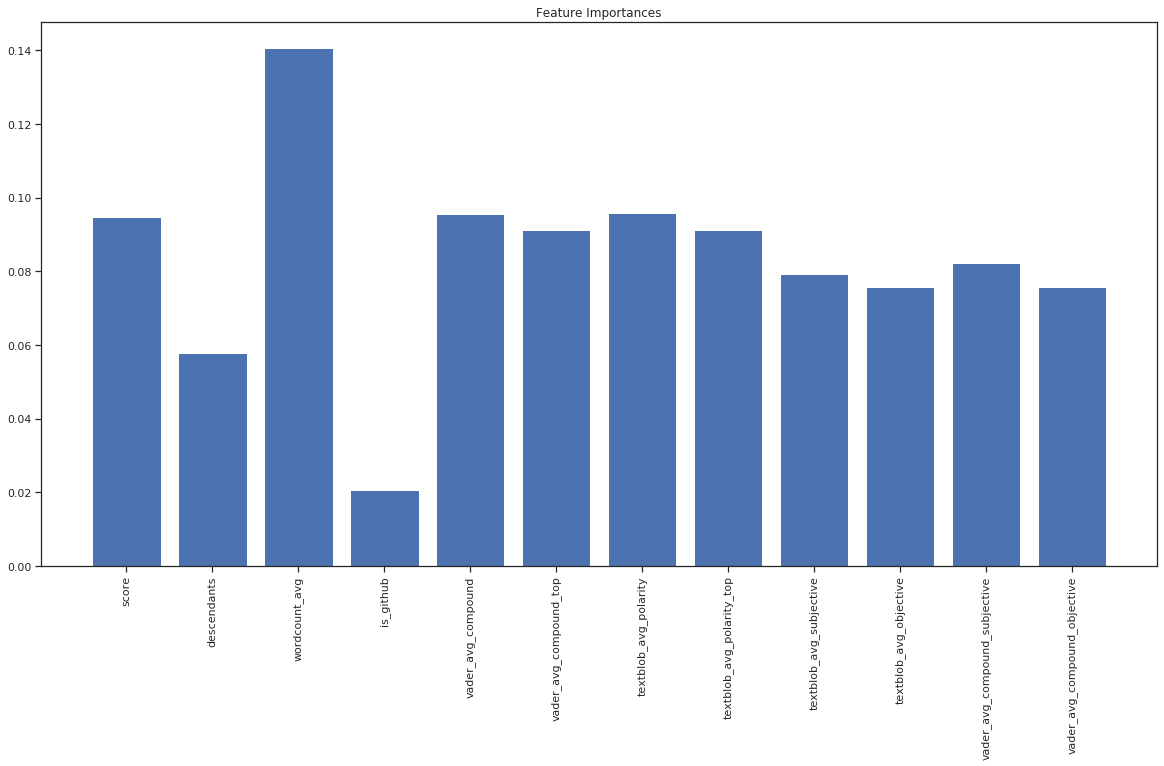

In [131]:
importances = m.feature_importances_

plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.bar(range(len(columns)),m.feature_importances_)
plt.xticks(range(len(columns)),X.columns, rotation=90)
plt.show()

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [128]:
y_train.isna().any()

active    True
dtype: bool

              precision    recall  f1-score   support

       False       0.62      0.94      0.75       903
        True       0.53      0.10      0.17       577

    accuracy                           0.61      1480
   macro avg       0.58      0.52      0.46      1480
weighted avg       0.59      0.61      0.52      1480

[[852  51]
 [519  58]]


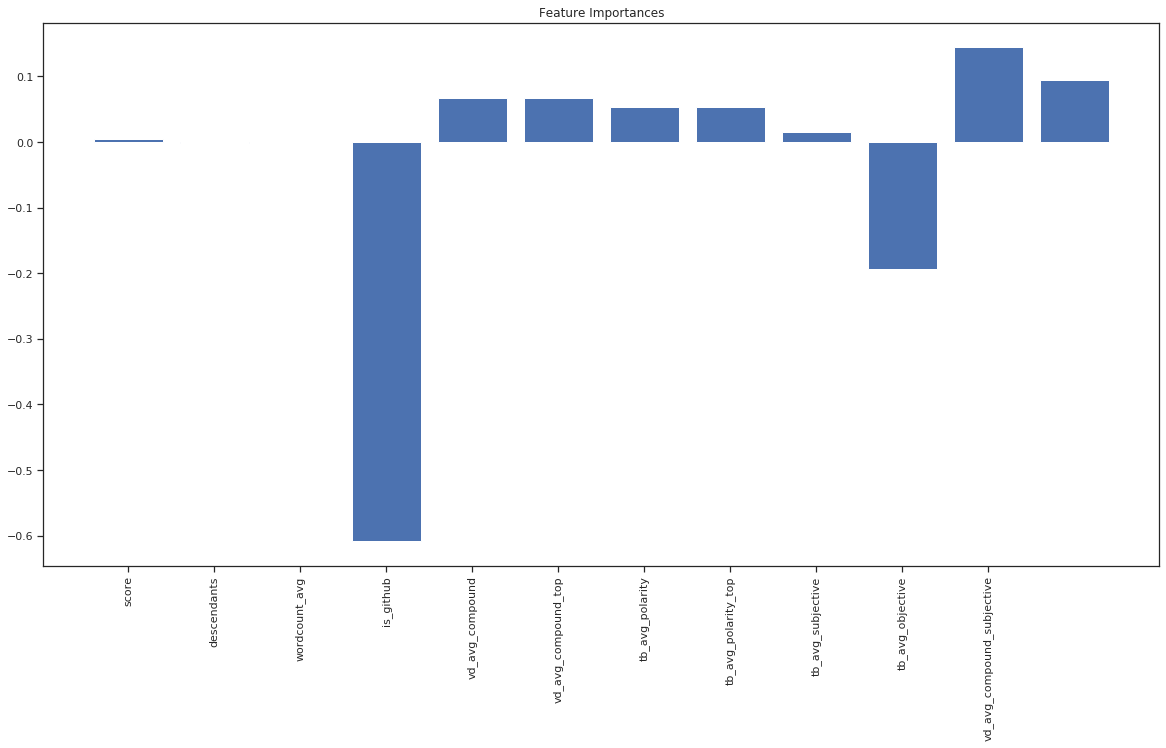

In [133]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.bar(range(len(columns)),model.coef_[0])
x_label = [
           c.replace("vader",'vd').replace('textblob', 'tb')
 for c in X.columns]
plt.xticks(range(11),x_label, rotation=90)
plt.show()

In [134]:
!pip install xgboost

In [135]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}

xgmodel = XGBClassifier()
xgmodel.fit(X_train, y_train)

y_pred = xgmodel.predict(X_test)
predictions = [round(value) for value in y_pred]

3
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))

Accuracy: 61.42%
              precision    recall  f1-score   support

       False       0.63      0.88      0.74       903
        True       0.51      0.20      0.28       577

    accuracy                           0.61      1480
   macro avg       0.57      0.54      0.51      1480
weighted avg       0.59      0.61      0.56      1480

[[796 107]
 [464 113]]
